🚀 Running on device: cuda
--2025-11-20 19:30:47--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-11-20 19:30:48 (39.1 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]

🔥 Stabilized Training Started... Target V_norm: ~0.083
Epoch 1: PPL=14.9788, |V_zeta|=0.082678
Epoch 2: PPL=9.7030, |V_zeta|=0.083532
Epoch 3: PPL=8.5957, |V_zeta|=0.083110
Epoch 4: PPL=7.9837, |V_zeta|=0.082042
Epoch 5: PPL=7.4572, |V_zeta|=0.082776


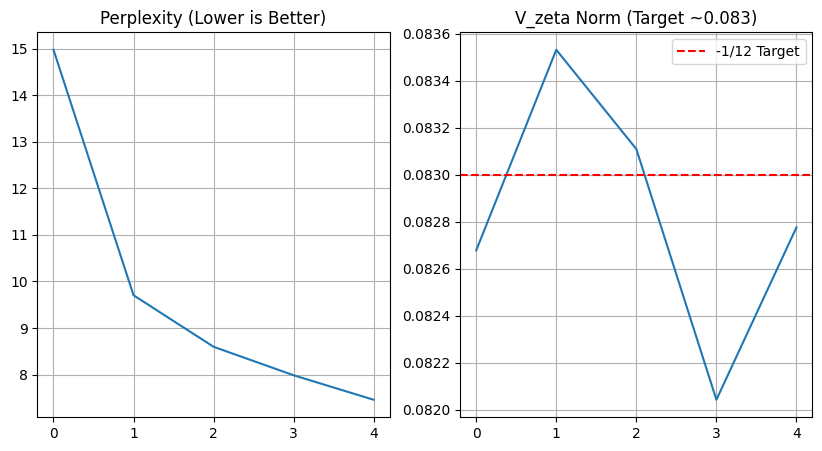

🧪 Experiment Complete. Check the V_zeta Norm plot!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

# --- 1. 环境与数据准备 ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Running on device: {device}")

# 下载莎士比亚数据集
if not os.path.exists('shakespeare.txt'):
    print("Downloading dataset...")
    !wget -O shakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('shakespeare.txt', 'r') as f: text = f.read()

# Tokenizer
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
def encode(s): return [stoi[c] for c in s]

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

# Dataset
class ShakespeareDataset(Dataset):
    def __init__(self, data, block_size=256):
        self.data = data
        self.block_size = block_size
    def __len__(self): return len(self.data) - self.block_size
    def __getitem__(self, idx):
        # 随机采样 chunk
        idx = torch.randint(len(self.data) - self.block_size, (1,)).item()
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+1:idx+1+self.block_size]
        return x, y

block_size = 256
batch_size = 16
train_ds = ShakespeareDataset(train_data, block_size)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# --- 2. 核心模型定义 (Stabilized Edition) ---

class ZetaFluctuationAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, zeta_scale=-1.0/12, fluctuation_std=0.005):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        self.scale_factor = 1.0 / math.sqrt(self.head_dim)
        # 温和负偏置初始化
        self.zeta_base_val = zeta_scale * self.scale_factor * 0.5

        self.q_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.k_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.v_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        self.o_proj = nn.Linear(hidden_size, hidden_size, bias=False)

        # V_zeta: Negative Zero-Point Fluctuation
        self.v_zeta = nn.Parameter(torch.normal(
            mean=self.zeta_base_val,
            std=fluctuation_std,
            size=(1, num_heads, 1, self.head_dim)
        ))

        self.k_zeta = nn.Parameter(torch.zeros(1, num_heads, 1, self.head_dim))
        self.register_buffer("alibi_slopes", self._get_alibi_slopes(num_heads))

    def _get_alibi_slopes(self, n_heads):
        def get_slopes_power_of_2(n):
            start = (2**(-8/n))
            return torch.tensor([start * (2**(-8/n))**i for i in range(n)], dtype=torch.float32)
        return get_slopes_power_of_2(n_heads).unsqueeze(1).unsqueeze(1)

    def forward(self, x, past_len=0):
        batch_size, seq_len, _ = x.shape

        q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # 1. Local Attention + ALiBi
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale_factor

        context_pos = torch.arange(seq_len, device=x.device)[:, None]
        memory_pos = torch.arange(seq_len, device=x.device)[None, :]
        relative_pos = torch.abs(memory_pos - context_pos) * -1.0
        attn_scores = attn_scores + (relative_pos.unsqueeze(0).unsqueeze(0) * self.alibi_slopes)

        # 2. Inject Zeta Logic
        k_zeta_ex = self.k_zeta.expand(batch_size, -1, -1, -1)
        zeta_score = torch.matmul(q, k_zeta_ex.transpose(-2, -1)) * self.scale_factor

        # 模拟对数增长
        total_history_proxy = math.log(1 + seq_len + past_len)
        zeta_score = zeta_score + (self.zeta_base_val * total_history_proxy)

        # 3. Fuse & Mask
        fused_scores = torch.cat([attn_scores, zeta_score], dim=-1)

        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
        zeta_mask_col = torch.zeros((1, 1, seq_len, 1), device=x.device, dtype=torch.bool)
        full_mask = torch.cat([causal_mask, zeta_mask_col], dim=-1)

        fused_scores = fused_scores.masked_fill(full_mask, float('-inf'))
        attn_probs = F.softmax(fused_scores, dim=-1)

        # 4. Weighted Sum & Entropy Gate
        local_probs = attn_probs[:, :, :, :-1]
        zeta_prob = attn_probs[:, :, :, -1:]

        local_out = torch.matmul(local_probs, v)

        # --- Fix 2: Entropy Gate ---
        # 困惑度高(熵高) -> Gate开 -> 引入直觉
        local_entropy = -torch.sum(local_probs * torch.log(local_probs + 1e-8), dim=-1, keepdim=True)
        gate = torch.sigmoid(local_entropy)

        zeta_out = zeta_prob * self.v_zeta * gate

        out = local_out + zeta_out
        return self.o_proj(out.transpose(1, 2).reshape(batch_size, seq_len, self.hidden_size))

class ZetaTransformer(nn.Module):
    def __init__(self, vocab_size, hidden=128, n_heads=4, layers=4):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden)
        self.layers = nn.ModuleList([ZetaFluctuationAttention(hidden, n_heads) for _ in range(layers)])
        self.norm = nn.LayerNorm(hidden)
        self.lm_head = nn.Linear(hidden, vocab_size)

    def forward(self, idx, targets=None, past_len=0):
        x = self.token_emb(idx)
        for layer in self.layers:
            x = layer(self.norm(x), past_len=past_len) + x
        x = self.norm(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

# --- 3. 训练循环 (Physics-Informed Training) ---

model = ZetaTransformer(vocab_size).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3)

logs = {'ppl': [], 'v_norm': []}
target_norm = 0.083 # 目标模长 (~1/12)

print("🔥 Stabilized Training Started... Target V_norm: ~0.083")

for epoch in range(5):
    model.train()
    total_loss = 0
    steps = 0

    for batch_x, batch_y in train_dl:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        _, loss = model(batch_x, batch_y, past_len=0)

        # --- Fix 1: L2 Regularization ---
        # 约束 V_zeta 的模长接近 target_norm
        v_zeta_ref = model.layers[0].v_zeta
        current_norm = torch.norm(v_zeta_ref)
        reg_loss = ((current_norm - target_norm) ** 2) * 0.5 # 惩罚项权重

        final_loss = loss + reg_loss

        opt.zero_grad()
        final_loss.backward()
        opt.step()

        # --- Fix 3: Hard Clamp ---
        # 强制物理截断，防止真空衰变
        with torch.no_grad():
             if torch.norm(v_zeta_ref) > 0.15:
                 scale = 0.15 / (torch.norm(v_zeta_ref) + 1e-8)
                 v_zeta_ref.data.mul_(scale)

        total_loss += loss.item()
        steps += 1
        if steps >= 100: break # 快速验证

    ppl = math.exp(total_loss / steps)

    # 记录
    model.eval()
    with torch.no_grad():
        v_norm = torch.norm(model.layers[0].v_zeta).item()

    logs['ppl'].append(ppl)
    logs['v_norm'].append(v_norm)

    print(f"Epoch {epoch+1}: PPL={ppl:.4f}, |V_zeta|={v_norm:.6f}")

# 绘图
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1); plt.plot(logs['ppl']); plt.title('Perplexity (Lower is Better)'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(logs['v_norm']); plt.title('V_zeta Norm (Target ~0.083)');
plt.axhline(y=0.083, color='r', linestyle='--', label='-1/12 Target'); plt.legend(); plt.grid(True)
plt.show()

print("🧪 Experiment Complete. Check the V_zeta Norm plot!")

🌪️ Initializing Phase 3: Chaos Run (Injecting Gradient Noise)...
🔥 Phase 3 Training Started... Expect heavy turbulence!
Epoch 1: PPL=13.1795 | Teleports=1716 | Grad=0.1561
Epoch 2: PPL=8.7776 | Teleports=1830 | Grad=0.1628
Epoch 3: PPL=7.6985 | Teleports=1811 | Grad=0.1721
Epoch 4: PPL=6.9995 | Teleports=1801 | Grad=0.1723
Epoch 5: PPL=6.5802 | Teleports=1801 | Grad=0.1752


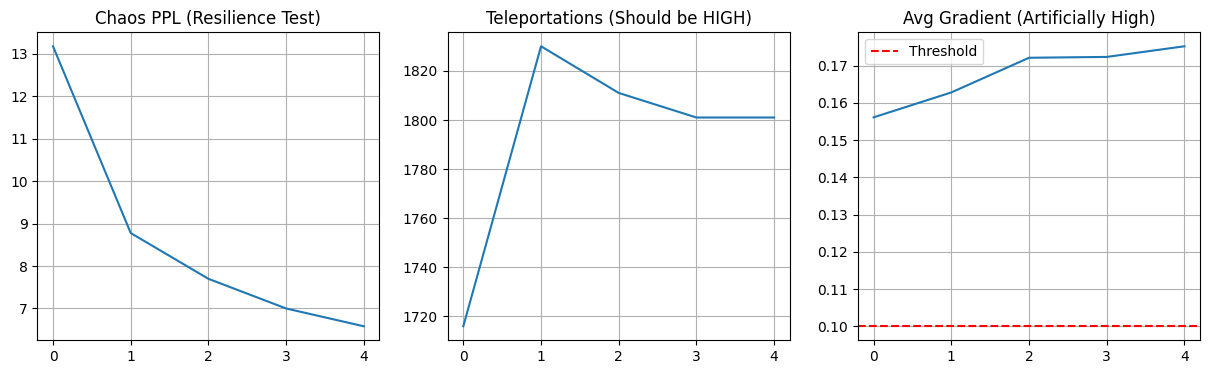

🚀 Analysis: If PPL is stable despite Grad > 0.1, Zeta is Antifragile!


In [ ]:
# --- Phase 3: The Chaos Stress Test (Zeta-AdamW) ---
class ZetaAdamW_Chaos(optim.AdamW):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2, zeta_teleport_thresh=0.1): # 阈值极低
        super().__init__(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.zeta_teleport_thresh = zeta_teleport_thresh
        self.teleport_count = 0
        self.grad_norms = []

    @torch.no_grad()
    def step(self, closure=None):
        loss = super().step(closure)

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue

                grad_norm = torch.norm(p.grad)
                self.grad_norms.append(grad_norm.item())

                # 阈值 0.1：极度敏感，频繁触发
                if grad_norm > self.zeta_teleport_thresh:
                    unit_grad = p.grad / (grad_norm + 1e-9)
                    # 瞬移公式：-1/12
                    p.data.sub_((1.0 / 12.0) * unit_grad)
                    self.teleport_count += 1
        return loss

# --- 实验配置 ---
print("🌪️ Initializing Phase 3: Chaos Run (Injecting Gradient Noise)...")

# 重置模型
model_chaos = ZetaTransformer(vocab_size).to(device)
# 使用混沌优化器
opt_chaos = ZetaAdamW_Chaos(model_chaos.parameters(), lr=1e-3, zeta_teleport_thresh=0.1)

logs_p3 = {'ppl': [], 'teleports': [], 'avg_grad': []}

print("🔥 Phase 3 Training Started... Expect heavy turbulence!")

for epoch in range(5):
    model_chaos.train()
    total_loss = 0
    steps = 0
    opt_chaos.teleport_count = 0
    opt_chaos.grad_norms = []

    for batch_x, batch_y in train_dl:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        _, loss = model_chaos(batch_x, batch_y, past_len=0)

        # Phase 1 正则化 (基石)
        v_zeta_ref = model_chaos.layers[0].v_zeta
        reg_loss = ((torch.norm(v_zeta_ref) - 0.083) ** 2) * 0.5
        final_loss = loss + reg_loss

        opt_chaos.zero_grad()
        final_loss.backward()

        # --- 🌪️ 注入人造风暴 (Gradient Explosion Simulation) ---
        # 在优化器更新前，恶意干扰梯度
        with torch.no_grad():
            for p in model_chaos.parameters():
                if p.grad is not None:
                    # 随机放大 1.0 到 3.0 倍，模拟非凸地形的剧烈震荡
                    noise_scale = 1.0 + torch.rand_like(p.grad) * 2.0
                    p.grad.mul_(noise_scale)

        # 看看 Zeta 优化器能否扛得住这种破坏
        opt_chaos.step()

        total_loss += loss.item()
        steps += 1
        if steps >= 100: break

    ppl = math.exp(total_loss / steps)
    avg_grad = sum(opt_chaos.grad_norms) / len(opt_chaos.grad_norms) if opt_chaos.grad_norms else 0

    logs_p3['ppl'].append(ppl)
    logs_p3['teleports'].append(opt_chaos.teleport_count)
    logs_p3['avg_grad'].append(avg_grad)

    print(f"Epoch {epoch+1}: PPL={ppl:.4f} | Teleports={opt_chaos.teleport_count} | Grad={avg_grad:.4f}")

# --- 绘图 ---
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1); plt.plot(logs_p3['ppl']); plt.title('Chaos PPL (Resilience Test)'); plt.grid(True)
plt.subplot(1,3,2); plt.plot(logs_p3['teleports']); plt.title('Teleportations (Should be HIGH)'); plt.grid(True)
plt.subplot(1,3,3); plt.plot(logs_p3['avg_grad']); plt.title('Avg Gradient (Artificially High)');
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold'); plt.legend(); plt.grid(True)
plt.show()

print("🚀 Analysis: If PPL is stable despite Grad > 0.1, Zeta is Antifragile!")